## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data.csv', delimiter=',')
data.describe()

,L1_S24_F1844,L1_S24_F1846,Response
count,54729.000000,54729.000000,54729.000000
mean,0.000834,-0.000758,0.010123
std,0.190919,0.134541,0.100102
min,-0.406000,-0.622000,0.000000
25%,-0.146000,-0.120000,0.000000
50%,0.000000,-0.001000,0.000000
75%,0.143000,0.125000,0.000000
max,0.556000,0.355000,1.000000


In [3]:
data.head(15)

,L1_S24_F1844,L1_S24_F1846,Response
0,-0.123,0.111,0
1,-0.269,0.175,0
2,-0.058,0.141,0
3,0.136,-0.145,0
4,0.045,-0.094,0
5,-0.152,0.181,0
6,0.233,0.045,0
7,0.327,-0.193,0
8,-0.020,-0.097,0
9,-0.029,0.122,0


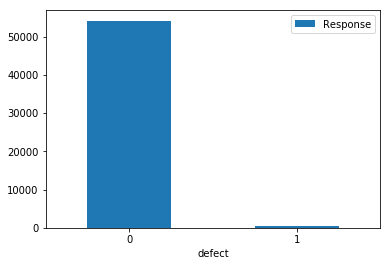

In [4]:
df = pd.DataFrame({'defect':['0', '1'], 'Response':data['Response'].value_counts().tolist()})
ax = df.plot.bar(x='defect', y='Response', rot=0)
plt.show()

## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [5]:
from sklearn.neighbors.kde import KernelDensity
import numpy as np

import matplotlib.pyplot as plt

/Users/alex_mezga/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

In [6]:
dens = []
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)

for val in (0, 1):
    i = data['Response'] == val
    kde = KernelDensity(kernel='exponential', bandwidth=0.1).fit(data.loc[i, 'L1_S24_F1846'].values.reshape(-1, 1))
    Dens = np.exp(kde.score_samples(X_plot))  # score_samples возвращает логарифм плотности
    dens.append(Dens)

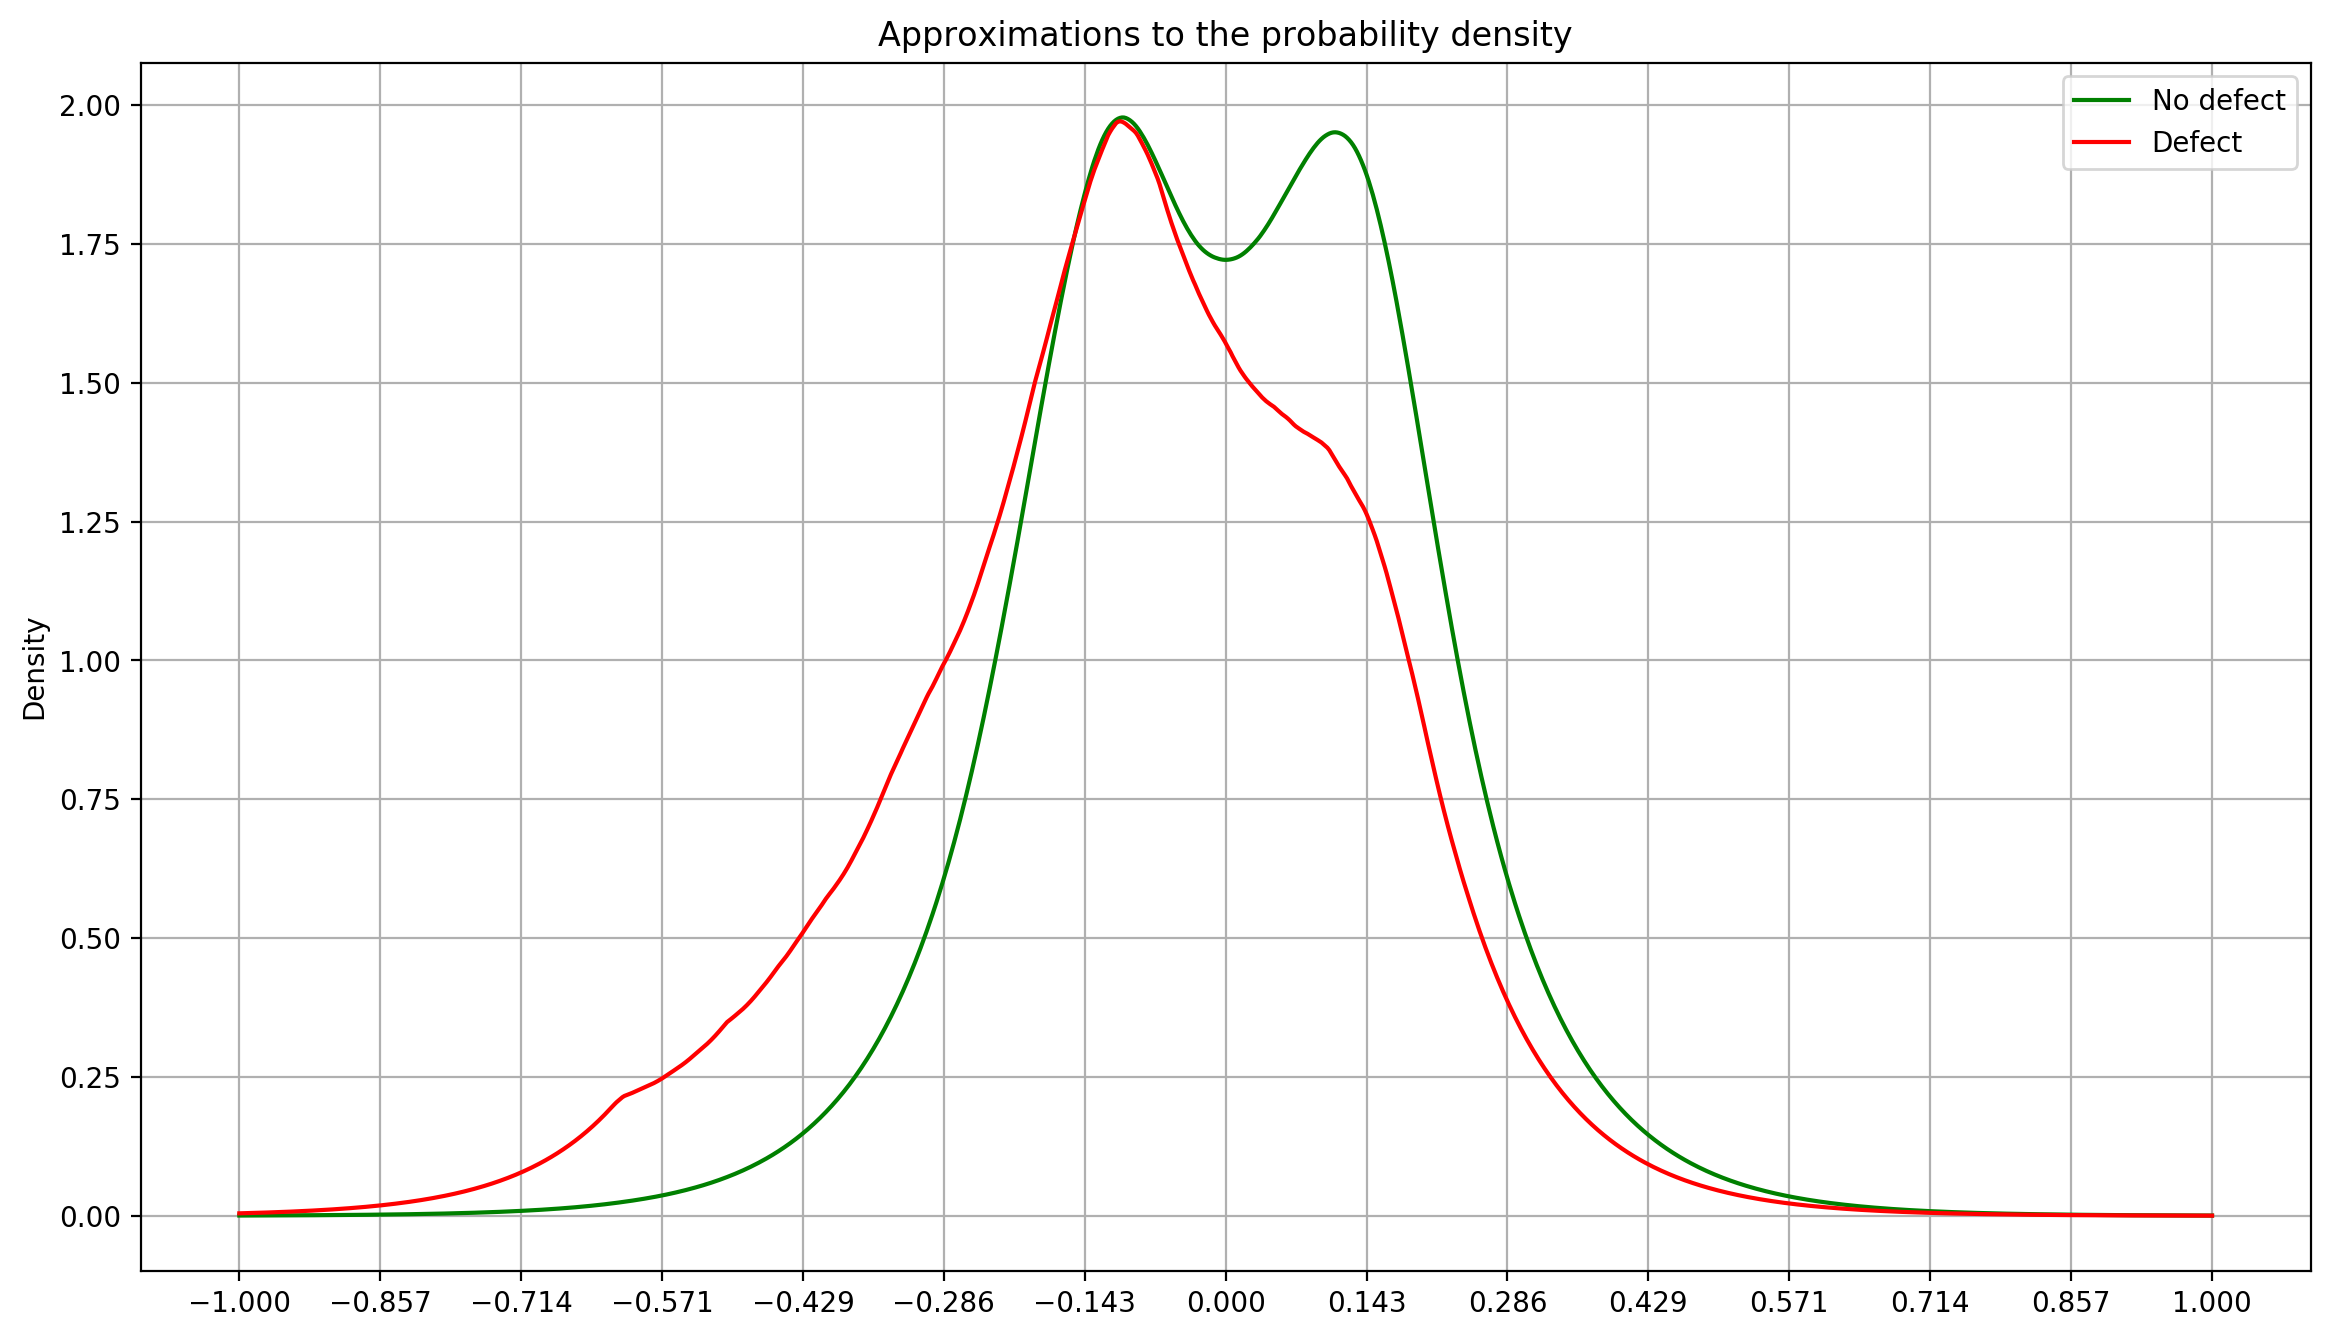

In [7]:
plt.figure(figsize=(14,8), dpi=200)

# values for making ticks in x axis
xnumbers = np.linspace(-1, 1, 15)

plt.plot(X_plot, dens[0], 'g', X_plot, dens[1], 'r') # r, g - red, green colour

plt.title("Approximations to the probability density")
plt.ylabel("Density")

plt.xticks(xnumbers)
plt.legend(['No defect', 'Defect'])
plt.grid()
plt.show()

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

Выборка не является хорошо разделимой

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [8]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)
    

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=5, random_state=45, shuffle=True)

def calculate_logLikehood(kde, r, train, test):
    kde.fit(train.loc[train['Response']==r, 
                      'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability = kde.score_samples(test.loc[test['Response']==r,
                                    'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability[np.isinf(logProbability)] = -100 # заменяем -бесконечность
    logLikehood = logProbability.sum()
    return logLikehood


logLikehoods = {}
for r in (0, 1):
    for bandwith in np.arange(0.005, 0.021, 0.005):
        kde = KernelDensity(kernel='exponential', bandwidth=bandwith)
        round_likehood = []
        
        for train, test in cv.split(data):
            train_data = data.loc[train].reset_index(drop=True)
            test_data = data.loc[test].reset_index(drop=True)
            logLikehood = calculate_logLikehood(kde, r, train_data, test_data)
            round_likehood.append(logLikehood)
            
        meanLikehood = np.mean(round_likehood)
        logLikehoods[f"{str(r)}-{str(bandwith)}"] =  meanLikehood  
        print(f"Current r: {r}")
        print(f"Current bandwith: {bandwith}")
        print(f"Current logLikehood: {meanLikehood}")

Current r: 0
Current bandwith: 0.005
Current logLikehood: 8936.789210839943
Current r: 0
Current bandwith: 0.01
Current logLikehood: 8897.413696110943
Current r: 0
Current bandwith: 0.015
Current logLikehood: 8853.475014473594
Current r: 0
Current bandwith: 0.02
Current logLikehood: 8778.850296365614
Current r: 0
Current bandwith: 0.005
Current logLikehood: 43.29895645103346
Current r: 0
Current bandwith: 0.01
Current logLikehood: 45.047959606601424
Current r: 0
Current bandwith: 0.015
Current logLikehood: 45.02198729142085
Current r: 0
Current bandwith: 0.02
Current logLikehood: 44.4946841294955


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [15]:
bandwith_0 = 0.005
bandwith_1 = 0.1

kde0 = KernelDensity(kernel='exponential', 
                     bandwidth=bandwith_0)
kde0.fit(dataTrain.loc[dataTrain['Response'] == 0, 
                       'L1_S24_F1846'].values.reshape(-1, 1))

kde1 = KernelDensity(kernel='exponential', 
                     bandwidth=bandwith_1)
kde1.fit(dataTrain.loc[dataTrain['Response'] == 1, 
                       'L1_S24_F1846'].values.reshape(-1, 1))

prediction0 = kde0.score(dataTest['L1_S24_F1846']
                         .values.reshape(-1, 1)) 
prediction1 = kde1.score(dataTest['L1_S24_F1846']
                         .values.reshape(-1, 1))

predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846']
                                                  .values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846']
                                                  .values.reshape(-1, 1)))

predictionProb = predictionProbXafter0 * prediction0 + predictionProbXafter1 * prediction1

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [16]:
predictionProb1afterX = (predictionProbXafter1 * prediction1) / predictionProb 
predictionProb0afterX = (predictionProbXafter0 * prediction0) / predictionProb

ind = np.argsort(predictionProb1afterX)
print(predictionProb1afterX[ind[-10:]])
print(sum(dataTest.loc[ind[-100:],'Response']))

[0.98793542 0.98793542 0.98793542 0.98944904 0.9905562  0.99726771
 0.99828513 0.99985472 0.99999731 0.99999993]
26
